# Deep Speech

## Introduction
- Deep Speech2의 핵심 성공 비결 3가지
    - 1. 음성 인식에 유리한 모델 아키텍처
    - 2. 대규모(1만 시간 가량) 학습 데이터 적용
    - 3. 효율적인 학습 테크닉 : CTC(Connectionist Temporal Classification) loss 직접 구현 
    

- 모델 구조는 아래와 같다.

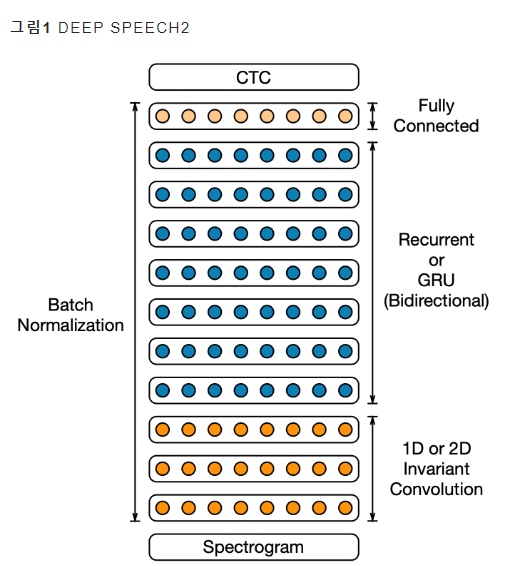

- 우선 음성 입력(Power Spectrogram)에서 중요한 특질(feature)을 뽑아내는 레이어로 CNN(Convolutional Neural Network)를 사용하고 있다.
- 이후 양방향(bidirectional) RNN(Recurrent Neural Network)를 두었다.
- 마지막에는 Fully Connected Layer가 자리잡는다.
- 레이어와 레이어 사이에는 Batch Normalization을 적용함.

## Convolution Layer
- Deep Speech2입력은 파워 스펙트로그램(Power Spectrogram)이다.
- **파워 스펙트로그램(Power Spectrogram)**이란?
    - 25ms 안팎 찰나의 주파수별 파워(Power)수치가 기록되어 있는 음성 피처를 스펙트럼(spectrum) 혹은 프레임(frame)이라고 한다.
    - 분석 대상 주파수 영역(bin)을 d개로 나눴을 경우 스펙트럼의 차원수는 d가 된다.
    (푸리에 변환 설명 참고)
    - 이걸 시간 축으로 쭉 나열한 것, 즉 프레임 시퀀스가 파워 스펙트로그램이다.
- 학습데이터 음성 길이는 각기 다를 수 있다.(음성이 길수록 프레임이 많아진다.)
- $i$번째 학습데이터의 프레임 갯수를 $T^{(i)}$라고 정의한다.
- 그림1 상단 행결을 Deep speech2입력 파워 스펙트럼이라고 보면 첫번째 행($d$차원 벡터)은 입력 읍성의 첫번째 프레임의 주파수별 파워, 첫번째 열($T^{(i)}$차원 벡터)은 첫번째 주파수 영역(bin)의 시간대별 파워가 된다.


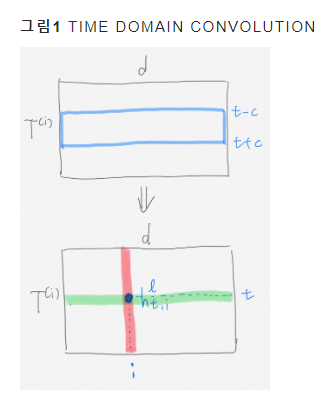

- Deep Speech2의 초기 레이어에서 벌어지는 컨볼루션 연산을 보면 $l$번째 레이어의 $t$번째 행, $i$번째 열에 해당하는 시간 축에 대한 컨볼루션(1D conv) 연산 결과 $h^{l}_{t,i}$는 아래 수식1처럼 정의된다.
- 여기에서 $c$는 컨볼루션 연산을 할 때 고려하는 컨텍스트(context)크기를 가리킨다.
- 이 값이 클수록 한번에 더 많은 이웃 프레임들을 본다.

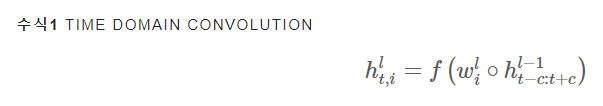

- 위 그림1은 입력 파워 스펙트로그램에 시간 축에 대한 컨볼루션 연산을 수행하는 과정을 도식적으로 나타낸 것이다.
- 그림1 상단 행렬의 파란색 칸이 $h^{l-1}_{t-c:t+c}$에 해당한다.
- 이것과 같은 크기의 가중치 행렬($w^l_i$)을 element-wise product를 수행하고 활성함수(activation function)를 적용한 것이 컨볼루션 연산이 된다.
- 저자들은 수식1의 활성함수 $f$로 **clipped ReLU**함수를 썼다.
- 일반적인 ReLU와 거의 유사하나 아웃풋 최대값을 20으로 제한했다.

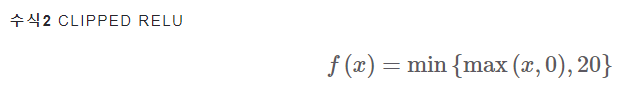

- 그림1 하단 행렬 $i$번째 열(붉은 선)은 $i$번째 필터, 즉 $w^l_i$가 시간 축을 따라 컨볼루션 연산을 수행한 결과를 가리킴.
- 다시 말해 $i$번째 열의 첫번째 스칼라 값은 $i$번째 필터가 첫번째 시점과 관계된 입력을 보고 계산한 아웃풋, 마지막 스칼라 값은 $i$번째 필터가 마지막 시점과 관계된 입력을 보고 계산한 아웃풋이 된다.

- 한편 $t$번째 행(녹색 선)은 컨볼루션 입력이 $h^{l-1}_{t-c:t+c}$로 같고 필터가 각기 다른 계산 결과를 나타낸다.
- 다시 말해 $t$번째 행의 첫번째 스칼라 값은 첫번째 필터의 아웃풋, 마지막 스칼라 값은 마지막 $d$번째 필터의 아웃풋이 된다.
- 그림1은 이해를 돕기 위해 패딩(padding)과 스트라이드(stride)등을 적절히 조절해 $T^{(i)}$가 줄어들지 않도록 그린 것이다.
- 실제 Deep Speech2 저자들은 컨볼루션 레이어를 여러 층을 쌓되 초기 레이어에는 스트라이드를 조금 크게 줘서 다음 레이어에서 계산할 프레임 갯수를 $T^{(i)}$보다 줄이는 서브샘플(sub-sample)방식을 적용함.

- 지금까지 예시로 설명한 것은 시간 축에 대한 컨볼루션 연산(1d conv)이었다. 
- 그림2에서 녹색 칸과 같다.
- $t^\prime$번째에서 $t''$번째 프레임(시간대)의 정보(time-only domain)를 취한다.
- 이 때 계산 대산 주파수 영역대는 d개 bin전체가 된다.

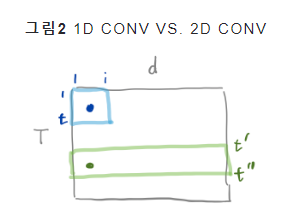

- 그런데 시간과 주파수 두 개 축에 대해 동시에 컨볼루션 연산(2d conv)을 수행할 수도 있다.
- 그림2에서 파란색 칸에 해당하는 영역을 컨볼루션(2d conv)할 경우 첫번째에서 $i$번째 주파수 영역대(bin), 첫번째에서 $t$번째 프레임(시간대)의 정보(**time-and-frequency domain**)를 취한다.
- 저자들에 따르면 1d conv보다는 2d conv를 적용한 모델의 인식 성능이 좋다고 한다.

## Bidirectional RNN Layer
- 이번에는 양방향 RNN 레이어를 쌓을 차례이다.
- 양방향 RNN 레이어 계산 방식은 수식3과 같다.
- 그림3은 수식3 이해를 돕기 위해 그렸다.
- 직전($l-1$)레이어의 $t$번째 시점 계산 결과 $h^{l-1}_t$를 순방향(forward), 역방향(backward) 레이어에 각각 입력한다.
- 순방향 레이어의 또다른 입력으로는 현재 레이어($l$) 직전 시점$(t-1)$의 계산 결과, 역방향 레이어의 또다른 입력으로는 현재 레이어($l$) 다음 시점($t+1$)의 계산 결과가 있다.
- $g$는 RNN함수를 가리킨다. vanilla RNN을 쓸 수도 있고  LSTM을 적용할 수도 있다.

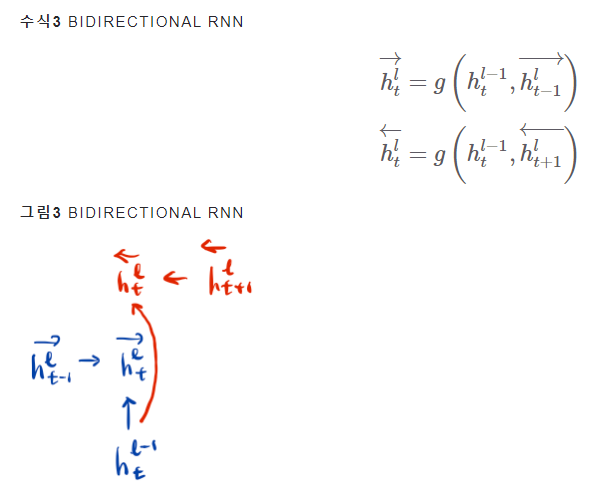

- 수식4를 일반적인 등식처럼 생각하면 헷갈릴 수 있다.
- 파이썬(python)코드를 작성하다보면 이미 계산된 결과에 추가로 계산을 수행해 같은 변수에 대입할 수 있다.
- 저자들은 이 방식으로 수식4를 작성한 듯 함.
- (책을 쓴 사람) 수식4를 양방향 계산 결과에 풀커넥티드 레이어(Fully Connected Layer)를 적용한 일종의 후처리라고 이해함.

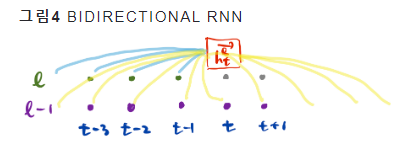

## Fully Connected / Softmax Layer
- 양방향 RNN 레이어 이후에 풀 커넥티드 레이어를 몇 층 쌓는다.(수식5와 같음)
- 직전 레이어가 양방향 RNN 마지막 레이어인 첫번째 풀 커넥티드 레이어의 $h^{l-1}_t$는 마지막 순방향 RNN 레이어의 계산 결과인 $\overrightarrow{h^{l-1}_t}$과 역방향 레이어의 결과물인 $\overleftarrow{h^{l-1}_t}$을 더해준 값
- 그 이후 풀 커넥티드 레이어에서는 $h^{l-1}_t$이 직전 풀 커넥티드 레이어의 계산 결과가 됨

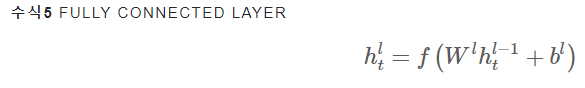

- 마지막 풀 커넥티드 레이어의 최종 계산 결과 $h^{L-1}_t$라고 할 때 소프트맥스 레이어는 수식6처럼 계산한다.
- $t$번째 프레임, $k$번째 범주에 관한 소프트맥스 확률값을 가리킨다.
- 저자들은 영어 음성 인식 모델의 경우 알파벳 26개, 공백, 아포스트로피(apostrophe), blank 등 29개 범주를 채택하고 있다.
- 수식6으로 계산한 모델 출력과 정답을 가지고 CTC loss를 계산한 뒤 역전파(backpropagation)을 수행해 모델을 학습한다.

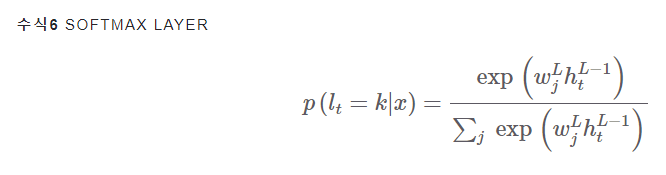

## Batch Normalization
- Deep Speech2 저자들은 선형변환(linear transformation)과 활성함수 $f$(clipped ReLU)가 연이어 나타나는 모든 곳(Conv, FC layer등)에 Batch Normalization을 수행하면 이동평균(moving average)을 빼주는 정규화 과정 때문에 바이어스 효과가 상쇄되기 때문이라고 설명한다.
- 이와 같은 원칙에 따라 양방향 RNN레이어(수식4)에도 Batch Normalization을 추가할 수 있다. 
- 학습 효율 증대를 위해 직전 레이어의 양방향 계산 결과(수식4의 첫번째 항)에 대해서만 Batch Normalization을 적용했다고 함.
- Batch Normalization이 효과를 발휘하려면 미니배치 내 모든 time step에 대해 mean과 variance를 계산할 수 있어야 하기 때문이라는 설명이다.(수식4의 두번째 항은 time step별로 잘게 쪼개서 통계량을 구해야 함.)
- 저자들이 RNN에 적용한 Batch Normalization은 수식7과 같다.

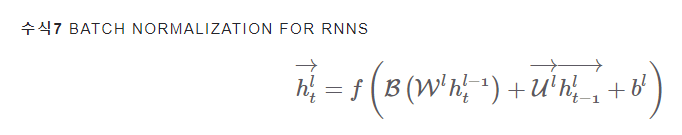

- 저자들에 따르면 각 Batch Normalization 블록의 평균과 분산의 이동평균을 학습할 때 구해놓고 이를 고정시킨 뒤 인퍼런스 환경에서 1개의 배치에 대해 Batch Normalization을 적용한 방식이, 인퍼런스 때 큰 배치를 쓰고 Batch Normalization을 수행하지 않는 방식보다 정확도가 더 높다고 한다.

## SortaGrad
- 저자들은 미니배치를 구성하는 방식을 CTC loss에 맞도록 변형했다.
- CTC loss는 그 특성상 음성 프레임 시퀀스 길이가 길어질 수록 손실과 그레디언트가 커진다.
- 미니배치별로 음성 프레임 시퀀스 길이가 들쭉날쭉하게 되면 learning rate를 고정한다고 해도 역전파되는 그래디언트의 길이가 불균등해진다.

- 게다가 RNN 아키텍처 특성상 입력 음성 프레임 시퀀스가 길어질 수록 그래디언트 문제가 발생할 수 있다.
- 이에 저자들은 음성 프레임 길이 순서로 학습데이터를 정렬한 뒤 미니배치 내 음성 최대 길이가 점차 늘어나게끔 미니배치 인입 순서를 정했다.
- 저자들은 이 같은 학습 방식을 **SortaGrad**라고 명명함.

## Dataset Contruction
- 학습데이터의 음성 길이는 짧게는 수분에서 길게는 1시간 이상인 것도 있다.
- 이를 모델에 통째로 넣고 학습하면 학습이 제대로 될 수 없다.
- 또 어떤 데이터는 음성 전사가 틀린 경우도 있다.
- 음성과 transcript가 불일치한 케이스는 학습에서 제외해야 한다.
- 이에 저자들은 데이터 구축을 위한 별도 모델을 만들어 이 문제를 해결함.

- 저자들은 alignment 용도로 **CTC loss를 적용한 양방향 RNN 레이어 모델**을 구축함.
- 입력은 파워 스펙트럼, 출력은 문자(grapheme)가 됨.
- CTC loss는 음성-trascript 쌍만 있으면 학습이 가능하다.
- 이렇게 학습한 alignment 모델에 학습데이터의 음성을 집어 넣는다.
- 모델 출력에 blank등의 레이블이 지속적으로 출현한다면 해당 구간을 앞뒤로 잘라서 음성을 분리(segmentation)하는 방식이다.

- 음성과 transcript 사이의 불일치 케이스를 가려내는 분류기 또한 만들었다.
- 분류기 구축하는 과정
    - 크라우드 소싱으로 음성 수천 건에 정답 transcript를 달아놓는다.
    - 앞서 만든 alignment 모델에 해당 음성을 넣어서 alignment 예측값을 추출한다.
    - 이 둘의 편집거리(edit distance)를 계산해 alignment가 잘 되었는지(good), 그렇지 않은지(bad)레이블을 부여한다.
    - 음성 스펙트로그램을 입력하고 good/bad를 출력하는 이진(binary)분류기를 별도로 학습한다.
    - 전체 학습데이터 음성 스펙트로그램을 이 분류기에 넣어 good으로 예측되는 데이터만 실제 모델 학습에 활용한다.

- 이 밖에 저자들은 학습데이터에 노이즈를 더해(adding noise)모델의 robustness를 키우려고 했음.
- 실험 결과 전체 가운데 40%를 랜덤으로 노이즈를 추가해 학습한 경우 인식 성능이 가장 좋았다고 함.
- 뿐만 아니라 학습데이터가 클수록 역시 인식 성능이 개선되는 양상을 보임.
- 참고로 저자들은 영어 인식기에 1만 1940시간의 학습데이터를 사용함.

## Experiments
- 논문에 제시된 여러 실험 결과 가운데 눈에 띄는 일부를 발췌 소개해 본다.
- 표1은 모델 크기(파라메터 수 3800만)를 고정시킨 상태에서 RNN 레이어 수와 RNN 히든 차원 수에 따른 영어 인식 성능 차이를 나타낸 것.
- 네 개 모델 모두 컨볼루션 레이어(1d)는 1개로 동일함.
- '7 RNN, 9 total' 이라는 말은 9개의 레이어 가운데 1개 레이어가 컨볼루션, 7개 레이어가 양방향 RNN, 나머지 1개 레이어가 Fully Connected Layer라는 뜻이다.
- 표1을 보면 두꺼운(히든이 큰) RNN 모델보다 깊은(레이어가 많은) 모델이 인식 성능이 좋은 것을 확인할 수 있다.

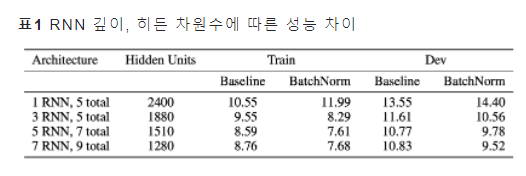

- 저자들은 RNN 함수 $g$를 valilla RNN 혹은 GRU를 적용한 모델을 각각 실험했는데 실험 환경별로 어느 한쪽이 우위를 보인다고 해석하기 어려웠다고 함.
- 표2는 컨볼루션 레이어를 어떻게 설정하느냐에 따른 성능 차이를 요약 정리한 표
- 전반적으로 1d conv보다 2d conv가 인식 성능이 좋음
- 음성 입력을 최초로 계산하는 **feature extractor**레이어에서는 시간(time)과 주파수(frequency) 도메인 모두 컨볼루션하는 것이 유의미하다는 이야기로 해석할 수 있을듯 함.

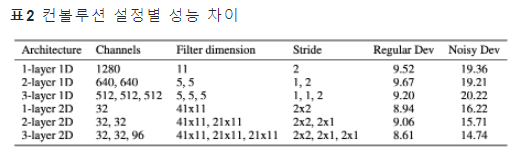

- 표3은 미니배치를 음성 길이에 따리 정렬해 짧은 것부터 순차적으로 학습한 모델(Sorted)과 그렇지 않은 모델(Not Sorted)의 성능 비교
- 정렬한 모델의 성능이 훨씬 좋은 것을 확인할 수 있다.
- RNN + CTC loss로 학습하는 모델에는 미니배치를 음성 길이에 따라 정렬하는 것이 유의미한 효과를 내는 것으로 해석할 수 있다.

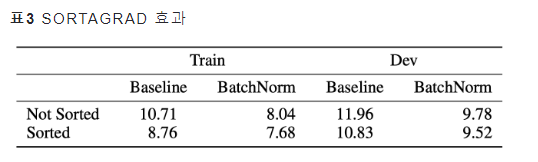

- 저자들이 실험한 결과 테스트 성능 최고점을 기록한 영어 인식기의 구조는 다음과 같다. 
- 아래 모든 레이어에는 Batch Normalization이 적용돼 있다.

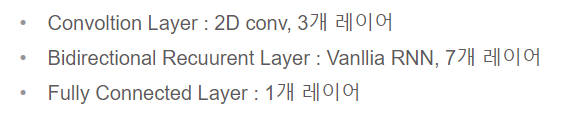